# **GA–PSO–Swarm Optimization for Breast-Cancer Classification (KNN)**

This notebook demonstrates how **Genetic Algorithm (GA)** and **Particle Swarm Optimization (PSO)**
can improve the performance of a **K-Nearest Neighbors (KNN)** classifier for
the *Breast Cancer Wisconsin Diagnostic* dataset.

**Goals**
1. 🧠 Build a KNN-based breast-cancer classifier.  
2. ⚙️ Optimize feature selection with GA.  
3. 🌀 Tune hyper-parameters with PSO.  
4. 🔗 Combine GA + PSO for hybrid optimization.  
5. 📈 Evaluate and visualize each experiment.

In [1]:
import numpy as np
import pandas as pd
from modules.data_loader import load_breast_cancer_data
from modules.preprocessing import split_and_scale
from modules.visualization import (
    plot_label_distribution, plot_heatmap, plot_feature_distributions,
    visualize_selected_features
)
from modules.ga import run_ga
from modules.pso import run_pso
from modules.evaluator import evaluate_model
from modules.hybrid import run_hybrid_ga_pso

## **Data**

The **Breast Cancer Wisconsin (Diagnostic)** dataset is downloaded directly from Kaggle
via `kagglehub`.  
Each sample describes cell-nucleus characteristics (30 numeric features) and
a target label:

- `1` → **Malignant**
- `0` → **Benign**

Data are split into 80 % train / 20 % test using `train_test_split`
and scaled to zero-mean and unit-variance with `StandardScaler`.

In [2]:
X, y = load_breast_cancer_data()
print(f"Shape of dataset: {X.shape}")
X.head()

Shape of dataset: (569, 30)


,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


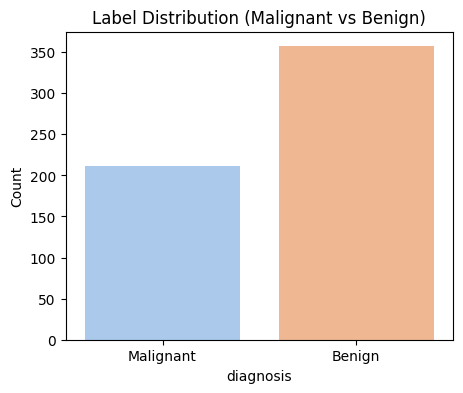

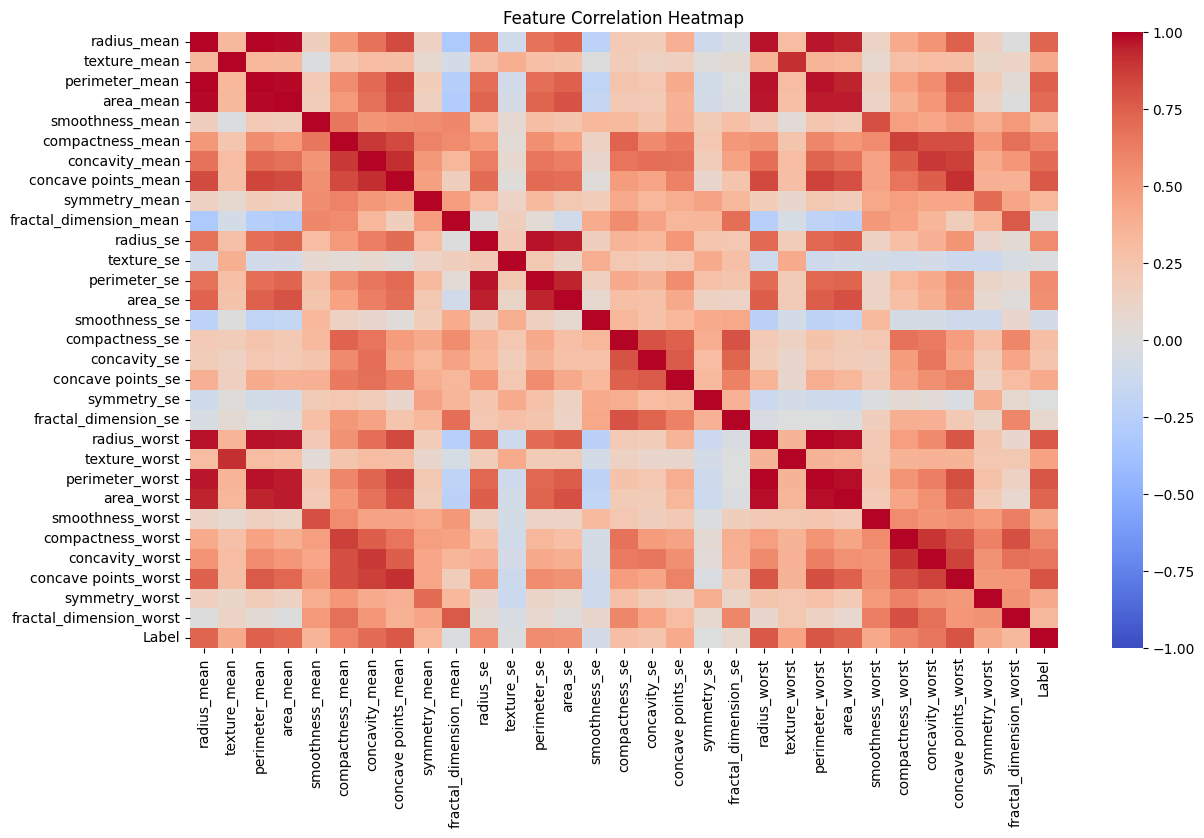

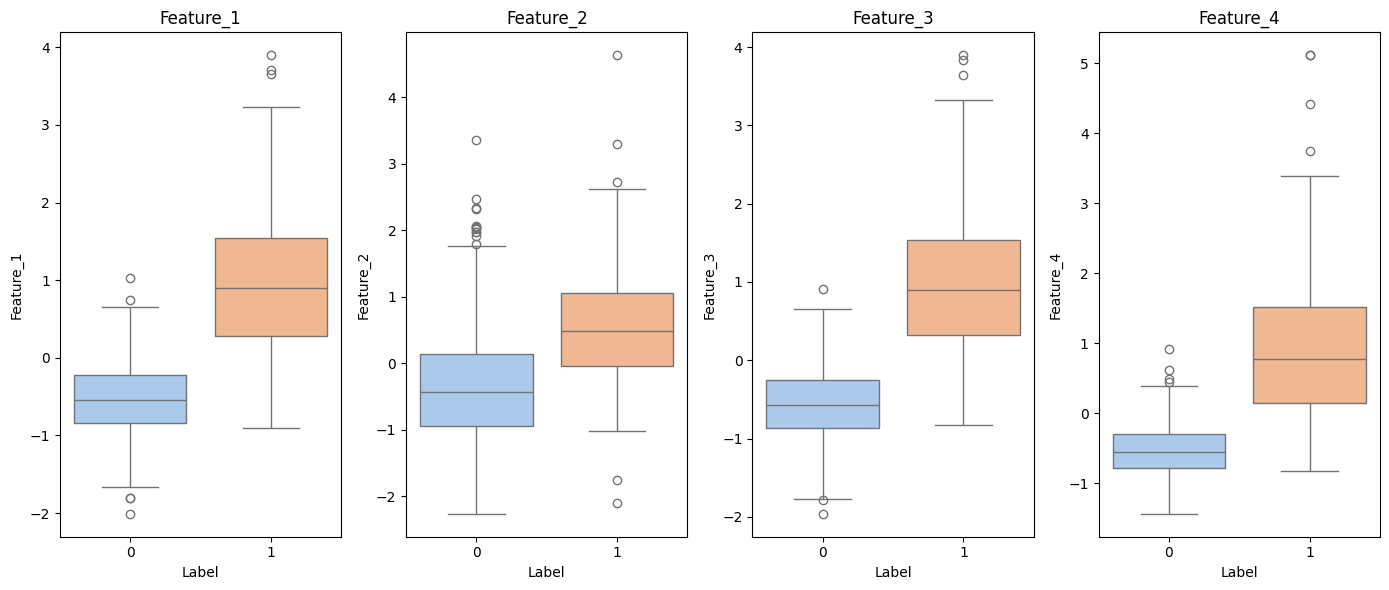

In [3]:
X_train, X_test, y_train, y_test = split_and_scale(X, y)

plot_label_distribution(y)
plot_heatmap(X, y)
plot_feature_distributions(X_train, y_train, [f"Feature_{i+1}" for i in range(4)])

## **Genetic Algorithm (GA)**

GA performs *feature selection* and *KNN parameter optimization* simultaneously.
Each chromosome:
- first 30 genes → feature mask (0/1 threshold 0.5)  
- gene 31 → number of neighbors *k* (3–15)  
- gene 32 → distance metric (0 = Euclidean, 1 = Manhattan)

Running Genetic Algorithm...
GA | Generation 1: Best Accuracy = 0.9648
GA | Generation 2: Best Accuracy = 0.9692
GA | Generation 3: Best Accuracy = 0.9692
GA | Generation 4: Best Accuracy = 0.9758
GA | Generation 5: Best Accuracy = 0.9758
GA | Generation 6: Best Accuracy = 0.9780
GA | Generation 7: Best Accuracy = 0.9780
GA | Generation 8: Best Accuracy = 0.9780
GA | Generation 9: Best Accuracy = 0.9802
GA | Generation 10: Best Accuracy = 0.9780
GA | Generation 11: Best Accuracy = 0.9780
GA | Generation 12: Best Accuracy = 0.9780
GA | Generation 13: Best Accuracy = 0.9780
GA | Generation 14: Best Accuracy = 0.9780
GA | Generation 15: Best Accuracy = 0.9780
GA | Generation 16: Best Accuracy = 0.9780
GA | Generation 17: Best Accuracy = 0.9780
GA | Generation 18: Best Accuracy = 0.9780
GA | Generation 19: Best Accuracy = 0.9780
GA | Generation 20: Best Accuracy = 0.9780
GA | Generation 21: Best Accuracy = 0.9780
GA | Generation 22: Best Accuracy = 0.9802
GA | Generation 23: Best Accuracy 

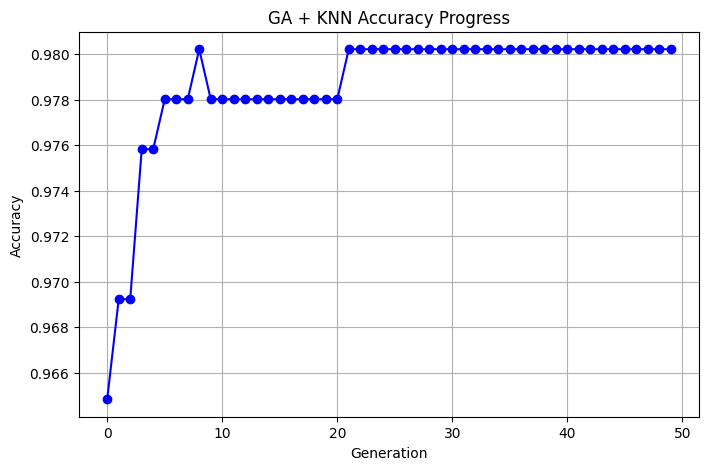


GA Results:
Selected features = 15/30
Best k = 3, Metric = euclidean

🔍 Evaluation — GA + KNN
Accuracy : 0.9649
Precision: 0.9524
Recall   : 0.9524
F1-score : 0.9524


In [4]:
print("Running Genetic Algorithm...")
best_ga = run_ga(X_train, y_train)

feature_mask_ga = best_ga[:30] >= 0.5
k_ga = int(np.clip(best_ga[30], 3, 15))
metric_ga = "euclidean" if best_ga[31] < 0.5 else "manhattan"

print(f"\nGA Results:\nSelected features = {feature_mask_ga.sum()}/30"
      f"\nBest k = {k_ga}, Metric = {metric_ga}")

# visualize_selected_features(X_train, y_train, feature_mask_ga, "GA")

ga_scores = evaluate_model(X_train, y_train, X_test, y_test,
                        feature_mask_ga, k_ga, metric_ga,
                        method="GA + KNN")

## **Particle Swarm Optimization (PSO)**

Each particle represents the same 32-dimensional solution.
Particles move through search-space using personal best (pbest)
and global best (gbest) feedback to maximize KNN accuracy.

Running PSO...
PSO | Iteration 1: Best Accuracy = 0.9736
PSO | Iteration 2: Best Accuracy = 0.9736
PSO | Iteration 3: Best Accuracy = 0.9736
PSO | Iteration 4: Best Accuracy = 0.9736
PSO | Iteration 5: Best Accuracy = 0.9736
PSO | Iteration 6: Best Accuracy = 0.9736
PSO | Iteration 7: Best Accuracy = 0.9736
PSO | Iteration 8: Best Accuracy = 0.9736
PSO | Iteration 9: Best Accuracy = 0.9736
PSO | Iteration 10: Best Accuracy = 0.9736
PSO | Iteration 11: Best Accuracy = 0.9736
PSO | Iteration 12: Best Accuracy = 0.9736
PSO | Iteration 13: Best Accuracy = 0.9736
PSO | Iteration 14: Best Accuracy = 0.9736
PSO | Iteration 15: Best Accuracy = 0.9736
PSO | Iteration 16: Best Accuracy = 0.9736
PSO | Iteration 17: Best Accuracy = 0.9736
PSO | Iteration 18: Best Accuracy = 0.9736
PSO | Iteration 19: Best Accuracy = 0.9736
PSO | Iteration 20: Best Accuracy = 0.9736
PSO | Iteration 21: Best Accuracy = 0.9736
PSO | Iteration 22: Best Accuracy = 0.9736
PSO | Iteration 23: Best Accuracy = 0.9736
PSO |

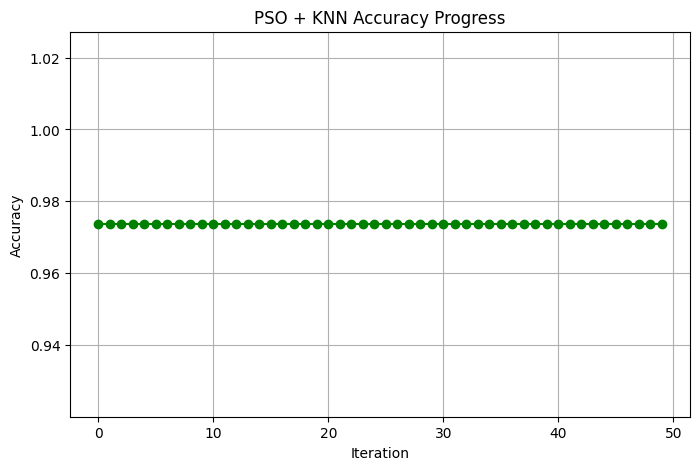


PSO Results:
Selected features = 15/30
Best k = 3, Metric = manhattan

🔍 Evaluation — PSO + KNN
Accuracy : 0.9474
Precision: 0.9737
Recall   : 0.8810
F1-score : 0.9250


In [5]:
print("Running PSO...")
best_pso = run_pso(X_train, y_train)

feature_mask_pso = best_pso[:30] >= 0.5
k_pso = int(np.clip(best_pso[30], 3, 15))
metric_pso = "euclidean" if best_pso[31] < 0.5 else "manhattan"

print(f"\nPSO Results:\nSelected features = {feature_mask_pso.sum()}/30"
      f"\nBest k = {k_pso}, Metric = {metric_pso}")

# visualize_selected_features(X_train, y_train, feature_mask_pso, "PSO")

pso_scores = evaluate_model(X_train, y_train, X_test, y_test,
                        feature_mask_pso, k_pso, metric_pso,
                        method="PSO + KNN")

## **Hybrid GA + PSO**

GA performs feature selection → PSO optimizes *k* and metric.
This sequential hybrid often yields a good balance
between model simplicity and accuracy.

Running Hybrid GA(FS) + PSO(HP)...
GA-FS | Gen 1: Best = 0.9780
GA-FS | Gen 2: Best = 0.9802
GA-FS | Gen 3: Best = 0.9802
GA-FS | Gen 4: Best = 0.9802
GA-FS | Gen 5: Best = 0.9824
GA-FS | Gen 6: Best = 0.9824
GA-FS | Gen 7: Best = 0.9824
GA-FS | Gen 8: Best = 0.9824
GA-FS | Gen 9: Best = 0.9824
GA-FS | Gen 10: Best = 0.9824
GA-FS | Gen 11: Best = 0.9824
GA-FS | Gen 12: Best = 0.9846
GA-FS | Gen 13: Best = 0.9846
GA-FS | Gen 14: Best = 0.9846
GA-FS | Gen 15: Best = 0.9846
GA-FS | Gen 16: Best = 0.9846
GA-FS | Gen 17: Best = 0.9846
GA-FS | Gen 18: Best = 0.9846
GA-FS | Gen 19: Best = 0.9846
GA-FS | Gen 20: Best = 0.9846
GA-FS | Gen 21: Best = 0.9846
GA-FS | Gen 22: Best = 0.9846
GA-FS | Gen 23: Best = 0.9846
GA-FS | Gen 24: Best = 0.9846
GA-FS | Gen 25: Best = 0.9846
GA-FS | Gen 26: Best = 0.9846
GA-FS | Gen 27: Best = 0.9846
GA-FS | Gen 28: Best = 0.9846
GA-FS | Gen 29: Best = 0.9846
GA-FS | Gen 30: Best = 0.9846


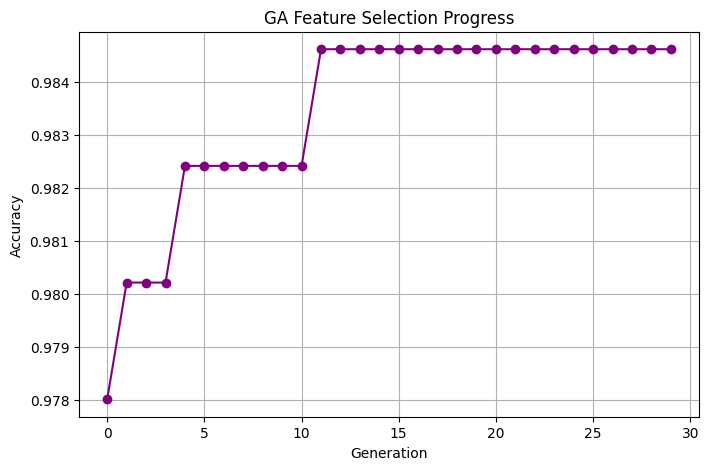

PSO-HP | Iter 1: Best = 0.9846
PSO-HP | Iter 2: Best = 0.9846
PSO-HP | Iter 3: Best = 0.9846
PSO-HP | Iter 4: Best = 0.9846
PSO-HP | Iter 5: Best = 0.9846
PSO-HP | Iter 6: Best = 0.9846
PSO-HP | Iter 7: Best = 0.9846
PSO-HP | Iter 8: Best = 0.9846
PSO-HP | Iter 9: Best = 0.9846
PSO-HP | Iter 10: Best = 0.9846
PSO-HP | Iter 11: Best = 0.9846
PSO-HP | Iter 12: Best = 0.9846
PSO-HP | Iter 13: Best = 0.9846
PSO-HP | Iter 14: Best = 0.9846
PSO-HP | Iter 15: Best = 0.9846
PSO-HP | Iter 16: Best = 0.9846
PSO-HP | Iter 17: Best = 0.9846
PSO-HP | Iter 18: Best = 0.9846
PSO-HP | Iter 19: Best = 0.9846
PSO-HP | Iter 20: Best = 0.9846
PSO-HP | Iter 21: Best = 0.9846
PSO-HP | Iter 22: Best = 0.9846
PSO-HP | Iter 23: Best = 0.9846
PSO-HP | Iter 24: Best = 0.9846
PSO-HP | Iter 25: Best = 0.9846
PSO-HP | Iter 26: Best = 0.9846
PSO-HP | Iter 27: Best = 0.9846
PSO-HP | Iter 28: Best = 0.9846
PSO-HP | Iter 29: Best = 0.9846
PSO-HP | Iter 30: Best = 0.9846


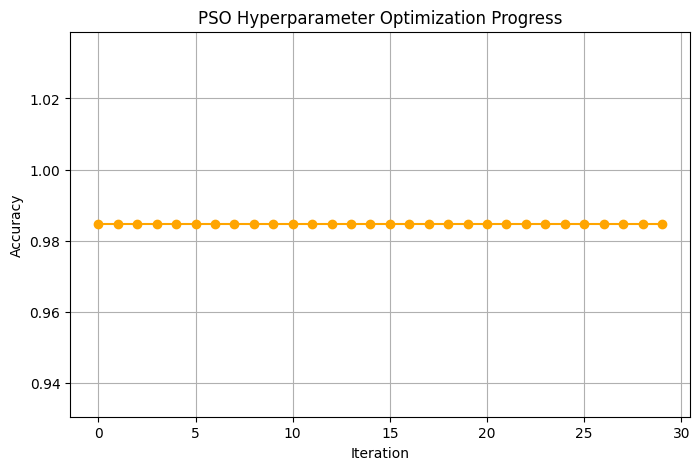

Hybrid GA+PSO | Best k=5, Metric=euclidean

🔍 Evaluation — GA(FS)+PSO(HP)+KNN
Accuracy : 0.9386
Precision: 0.9730
Recall   : 0.8571
F1-score : 0.9114


In [6]:

print("Running Hybrid GA(FS) + PSO(HP)...")
feature_mask_hybrid, k_hybrid, metric_hybrid = run_hybrid_ga_pso(X_train, y_train)

# visualize_selected_features(X_train, y_train, feature_mask_hybrid, "GA(FS)+PSO(HP)")

hybrid_scores = evaluate_model(X_train, y_train, X_test, y_test,
                              feature_mask_hybrid, k_hybrid, metric_hybrid,
                              method="GA(FS)+PSO(HP)+KNN")

In [7]:
results = pd.DataFrame([ga_scores, pso_scores, hybrid_scores])
display(results.style.background_gradient(cmap="Blues"))

,Method,Accuracy,Precision,Recall,F1
0,GA + KNN,0.964900,0.952400,0.952400,0.952400
1,PSO + KNN,0.947400,0.973700,0.881000,0.925000
2,GA(FS)+PSO(HP)+KNN,0.938600,0.973000,0.857100,0.911400


## **Analysis**

Genetic Algorithm (GA + KNN) achieved the highest overall balance between accuracy, precision, and recall, reaching an accuracy of 96.49% and an F1-score of 0.9524.
The Particle Swarm Optimization (PSO + KNN) model produced the highest precision (0.9737), meaning it is highly reliable in identifying malignant samples, but its recall (0.8810) indicates it missed some true positives (malignant cases).
The hybrid GA(FS) + PSO(HP) + KNN showed slightly lower performance across all metrics, particularly in recall (0.8571), which implies reduced sensitivity toward positive (malignant) predictions.

Overall, GA alone produced the most stable results with balanced precision and recall, suggesting that feature selection plays a more critical role than additional hyperparameter fine-tuning in this dataset.

## **Conclusion**

The results demonstrate that both Genetic Algorithm (GA) and Particle Swarm Optimization (PSO) are effective metaheuristic approaches for optimizing KNN performance on the Breast Cancer Wisconsin dataset.
Among all configurations:

GA + KNN achieved the best trade-off between predictive accuracy and sensitivity.

PSO + KNN slightly improved precision but at the cost of lower recall, indicating a conservative classification boundary.

The hybrid GA(FS) + PSO(HP) + KNN did not outperform the individual optimizers, likely due to overlapping search behavior and potential overfitting to training features.

In conclusion, Genetic Algorithm optimization is the most effective standalone method for this classification problem, providing robust and interpretable feature selection while maintaining high accuracy and balanced classification performance.